## Weather Classification
### Data Preprocessing

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assemble pipeline(s)
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector

# Features engineering
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.outliers import OutlierTrimmer

In [271]:
# Dsplay pipelines
from sklearn import set_config
set_config(display="diagram")

In [272]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [273]:
# Weather Classification dataset
# It contains 21 columns including the target variable RainTomorrow (YES/NO).
df = pd.read_excel('../../../data/weather-data.xls')
df.sample(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
14850,2016-11-12,Region5,20.2,36.0,0.0,WNW,50.0,NNE,NaN,17.0,...,63.0,29.0,1006.7,1002.3,8.0,2.0,24.7,34.5,No,No
34237,2010-12-19,Region12,17.3,28.3,0.0,N,69.0,NW,N,9.0,...,65.0,36.0,1003.7,995.0,6.0,4.0,20.7,26.5,No,Yes
20459,2015-09-05,Region7,12.3,20.2,NaN,SE,43.0,WNW,SSE,6.0,...,77.0,57.0,1022.1,1019.3,NaN,NaN,16.4,18.4,NaN,NaN
3162,2009-05-03,Region2,8.5,21.9,0.0,SSW,24.0,SW,E,17.0,...,73.0,52.0,1027.9,1025.6,NaN,NaN,15.3,20.8,No,No
35705,2015-03-25,Region12,15.2,23.2,14.6,SSW,54.0,WNW,S,13.0,...,69.0,63.0,1017.3,1016.8,1.0,3.0,18.5,21.8,Yes,No
9304,2009-09-04,Region4,15.8,23.6,0.6,NNE,50.0,N,NNE,9.0,...,64.0,77.0,1019.3,1014.1,7.0,7.0,18.3,19.5,No,Yes
30797,2009-10-14,Region11,15.2,22.1,0.0,NaN,NaN,NW,WNW,20.0,...,36.0,34.0,1000.7,1000.7,1.0,5.0,19.7,17.8,No,No
17299,2015-04-01,Region6,16.0,27.2,11.6,NaN,NaN,NaN,NaN,0.0,...,100.0,NaN,NaN,NaN,7.0,NaN,18.0,NaN,Yes,No
8180,2015-01-30,Region3,17.0,30.5,0.0,WSW,41.0,SSE,W,7.0,...,31.0,12.0,1009.7,1006.5,1.0,1.0,22.7,29.1,No,No
53,2009-01-23,Region1,18.8,35.2,6.4,WNW,52.0,S,NW,6.0,...,43.0,28.0,1007.9,1003.9,NaN,NaN,22.8,33.0,Yes,No


In [274]:
df.shape

(36529, 21)

## Prepare target Variable

In [275]:
# Convert the target variable to categorical order form.
df.rename(columns={'RainTomorrow':'target'}, inplace=True)

In [276]:
list(df['target'].unique())

['No', 'Yes', nan]

In [277]:
# Handle missing values in target variable
ci = CategoricalImputer(imputation_method='frequent', variables=['target'])
df = ci.fit_transform(df)
list(df['target'].unique())

['No', 'Yes']

In [278]:
df['target'].replace({'No':0, 'Yes':1}, inplace=True)
target_type = pd.CategoricalDtype(categories=sorted(df.target.unique()), ordered=True)
df["target"] = df["target"].astype(target_type)

## Handle features datatypes

In [279]:
# Know the datatypes
df.dtypes

Date             datetime64[ns]
Location                 object
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
WindGustDir              object
WindGustSpeed           float64
WindDir9am               object
WindDir3pm               object
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am             float64
Humidity3pm             float64
Pressure9am             float64
Pressure3pm             float64
Cloud9am                float64
Cloud3pm                float64
Temp9am                 float64
Temp3pm                 float64
RainToday                object
target                 category
dtype: object

In [280]:
# Convert categorical features to categorical datatype.
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [281]:
df.dtypes

Date             datetime64[ns]
Location               category
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
WindGustDir            category
WindGustSpeed           float64
WindDir9am             category
WindDir3pm             category
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am             float64
Humidity3pm             float64
Pressure9am             float64
Pressure3pm             float64
Cloud9am                float64
Cloud3pm                float64
Temp9am                 float64
Temp3pm                 float64
RainToday              category
target                 category
dtype: object

In [283]:
# Checked the Descriptive Statistics
df.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,36029.000000,36160.000000,35839.000000,31597.000000,35698.000000,35054.000000,35862.000000,35196.000000,29837.000000,29846.000000,20712.000000,20390.000000,36092.000000,35424.000000
mean,13.413489,23.956333,2.696772,38.360287,12.662978,17.413904,70.032820,52.508581,1018.259165,1015.698485,4.312331,4.401422,17.861931,22.478128
std,5.723398,5.914569,9.410816,13.706660,9.126107,9.316727,17.508474,20.387986,6.648539,6.597083,2.913795,2.703880,5.290466,5.750985
min,-4.800000,6.800000,0.000000,7.000000,0.000000,0.000000,3.000000,1.000000,980.500000,979.000000,0.000000,0.000000,0.300000,6.400000
25%,9.200000,19.500000,0.000000,30.000000,6.000000,11.000000,58.000000,37.000000,1013.800000,1011.300000,1.000000,2.000000,14.100000,18.200000
50%,14.000000,23.400000,0.000000,37.000000,11.000000,17.000000,71.000000,53.000000,1018.300000,1015.800000,5.000000,5.000000,18.300000,21.800000
75%,18.000000,27.500000,0.800000,46.000000,19.000000,22.000000,83.000000,67.000000,1022.700000,1020.200000,7.000000,7.000000,21.800000,25.900000
max,29.700000,47.300000,371.000000,135.000000,130.000000,83.000000,100.000000,100.000000,1039.900000,1037.000000,9.000000,8.000000,37.700000,46.700000


In [284]:
# sns.pairplot(df, hue='target', corner=True, palette='coolwarm')
# plt.show()

## Duplicates dropping

In [285]:
# Duplicates dropping
nrows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f'Now of rows dropped: {nrows - df.shape[0]}')

Now of rows dropped: 0


## Outliers Removal

<function matplotlib.pyplot.show(close=None, block=None)>

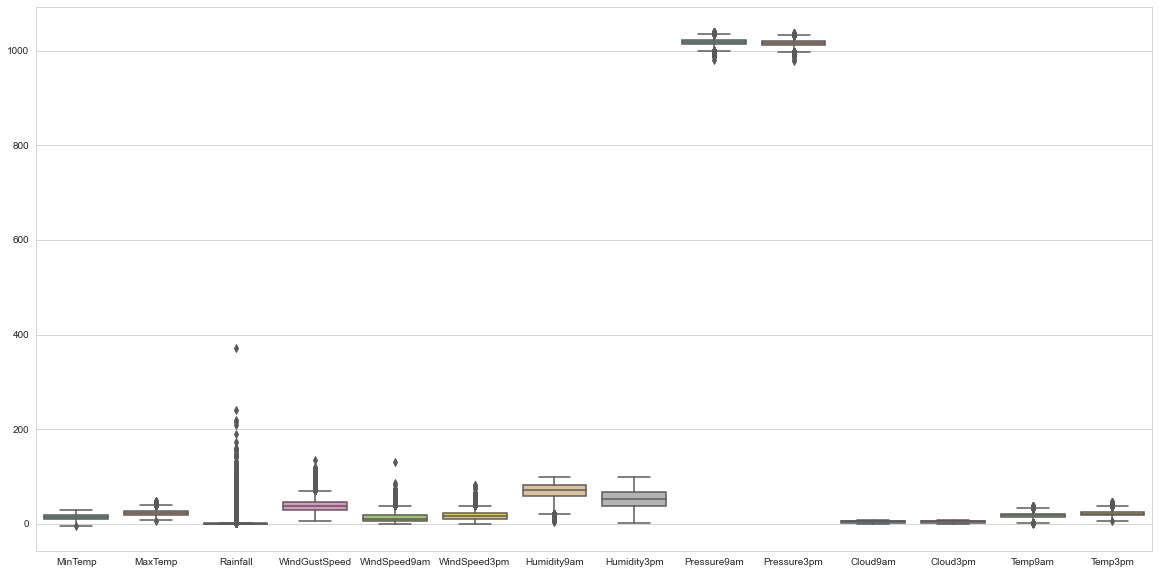

In [286]:
# Check Outliers
plt.figure(figsize=(20, 10))
sns.boxplot(data=df, orient="v", palette="Set2")
plt.show

We observed existence of outliers for features: "Rainfall", "WindGustSpeed","WindSpeed9am", "WindSpeed3pm", "Humidity9am"

In [287]:
# Remove outliers
ot = OutlierTrimmer(capping_method='gaussian', tail='both', fold=3, missing_values='ignore', variables=['Rainfall', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am'])
ot.fit(df)

OutlierTrimmer(missing_values='ignore', tail='both',
               variables=['Rainfall', 'WindGustSpeed', 'WindSpeed9am',
                          'WindSpeed3pm', 'Humidity9am'])

In [288]:
print("Minimum caps :", ot.left_tail_caps_)
print("Maximum caps :", ot.right_tail_caps_)

Minimum caps : {'Rainfall': -25.53528340731494, 'WindGustSpeed': -2.7590422177490623, 'WindSpeed9am': -14.714959462043973, 'WindSpeed3pm': -10.53587860860912, 'Humidity9am': 17.50812931793071}
Maximum caps : {'Rainfall': 30.928826753948496, 'WindGustSpeed': 79.4796169558571, 'WindSpeed9am': 40.040916098270095, 'WindSpeed3pm': 45.363687132600674, 'Humidity9am': 122.55751119291644}


In [289]:
df_out = ot.transform(df)

In [290]:
print("train data shape after removing outliers:", df_out.shape)
print(f"{df.shape[0] - df_out.shape[0]} observations are removed\n")

train data shape after removing outliers: (29679, 21)
6850 observations are removed



<function matplotlib.pyplot.show(close=None, block=None)>

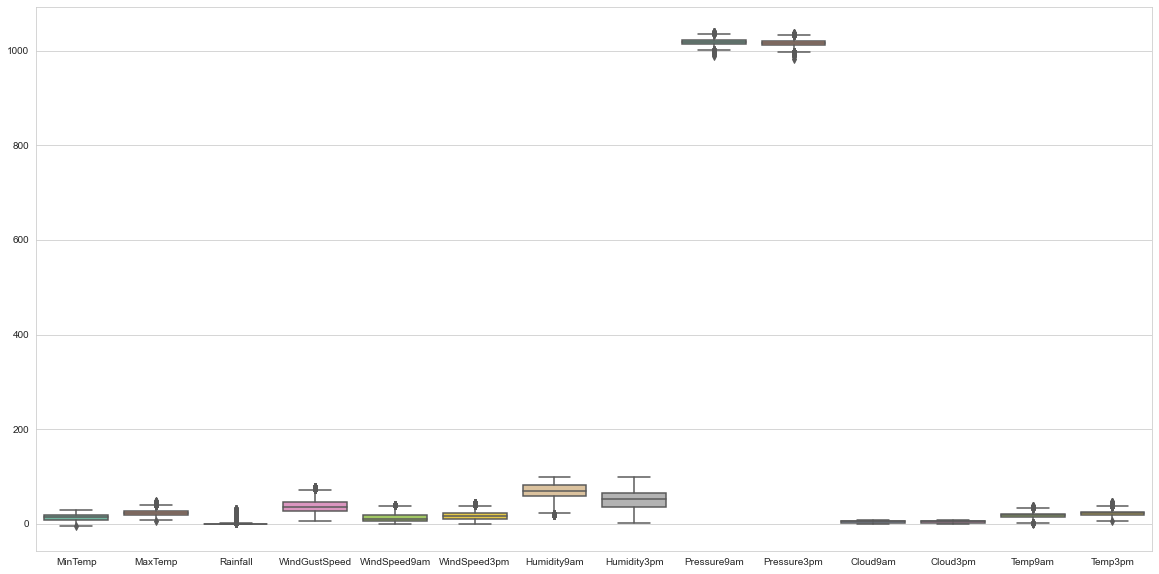

In [291]:
# Check Outliers
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_out, orient="v", palette="Set2")
plt.show

## Handling Missing Data

In [292]:
# Check Null Data
df_out.isnull().sum()

Date                 0
Location             0
MinTemp              8
MaxTemp             10
Rainfall             0
WindGustDir          3
WindGustSpeed        0
WindDir9am        2351
WindDir3pm         233
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm         25
Pressure9am       2979
Pressure3pm       2969
Cloud9am         13967
Cloud3pm         13661
Temp9am              0
Temp3pm              4
RainToday            0
target               0
dtype: int64

In [294]:
# Selecting categorical and numeric features
sel_numeric = make_column_selector(dtype_include=['number'])
col_numerical = sel_numeric(df_out)

sel_categorical = make_column_selector(dtype_include=['object','category'])
col_categorical = sel_categorical(df_out)

sel_datetime = make_column_selector(dtype_include=['datetime','datetimetz','timedelta'])
col_datetime = sel_datetime(df_out)

ppl_imp = Pipeline([
    # Step 1: Impute features
    ('num', MeanMedianImputer(imputation_method='median', variables=col_numerical)),
    ('cat', CategoricalImputer(imputation_method='frequent', variables=col_categorical))
])

In [295]:
display(ppl_imp)

Pipeline(steps=[('num',
                 MeanMedianImputer(variables=['MinTemp', 'MaxTemp', 'Rainfall',
                                              'WindGustSpeed', 'WindSpeed9am',
                                              'WindSpeed3pm', 'Humidity9am',
                                              'Humidity3pm', 'Pressure9am',
                                              'Pressure3pm', 'Cloud9am',
                                              'Cloud3pm', 'Temp9am',
                                              'Temp3pm'])),
                ('cat',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['Location', 'WindGustDir',
                                               'WindDir9am', 'WindDir3pm',
                                               'RainToday', 'target']))])

In [296]:
X_im = ppl_imp.fit_transform(df_out)
X_im

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,target
0,2008-12-01,Region1,13.4,22.9,0.6,W,44.0,W,WNW,20.0,...,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No,0
1,2008-12-02,Region1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,No,0
2,2008-12-03,Region1,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,No,0
3,2008-12-04,Region1,9.2,28.0,0.0,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,No,0
4,2008-12-05,Region1,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36524,2017-06-21,Region12,8.6,18.6,0.2,SSW,56.0,NNW,S,13.0,...,69.0,67.0,1025.7,1025.3,2.0,2.0,13.3,17.7,No,0
36525,2017-06-22,Region12,9.5,17.8,0.2,SW,35.0,NNW,SSE,9.0,...,74.0,70.0,1028.3,1024.6,2.0,2.0,14.3,16.8,No,0
36526,2017-06-23,Region12,8.7,19.4,0.0,NNW,30.0,NW,NW,13.0,...,83.0,57.0,1020.8,1014.7,6.0,6.0,10.9,18.2,No,0
36527,2017-06-24,Region12,9.4,19.9,0.0,SW,43.0,WNW,W,22.0,...,61.0,41.0,1017.3,1015.2,5.0,2.0,12.9,19.3,No,0


In [297]:
# Check Null Data
X_im.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
target           0
dtype: int64

## Save cleaned data

In [298]:
#X_train, X_test, y_train, y_test = train_test_split(X_im, y, test_size=0.2)
#df_train_clean = pd.concat([X_train, y_train], axis=1)
#df_test_clean = pd.concat([X_test, y_test], axis=1)
X_im.to_csv('../../../data/weather-classification-clean.csv', index=False)